In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/My_classes/AIT-CV-2024/SlideShare/week-4-resources

ModuleNotFoundError: No module named 'google.colab'

# Step 1: Read Reference and scanned images

In [5]:
# Read reference image
im1 = cv2.imread("refDatabricks.jpg", cv2.IMREAD_COLOR)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

# Read image to be aligned
im2 = cv2.imread("databricks.jpg", cv2.IMREAD_COLOR)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

Text(0.5, 1.0, 'Scanned')

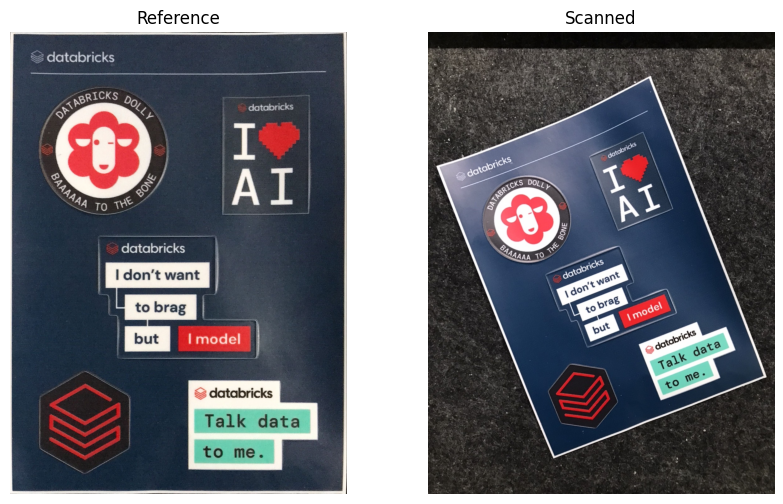

In [6]:
plt.figure(figsize=[10,6]);
plt.subplot(121); plt.axis('off'); plt.imshow(im1); plt.title("Reference")
plt.subplot(122); plt.axis('off'); plt.imshow(im2); plt.title("Scanned")

# Step 2: Find keypoints in both Images

In [7]:
# Convert images to grayscale
im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
keypoints1, descriptors1 = sift.detectAndCompute(im1_gray,None)
keypoints2, descriptors2 = sift.detectAndCompute(im2_gray,None)

# # Detect ORB features and compute descriptors.
# MAX_NUM_FEATURES = 500
# orb = cv2.ORB_create(MAX_NUM_FEATURES)
# keypoints1, descriptors1 = orb.detectAndCompute(im1_gray, None)
# keypoints2, descriptors2 = orb.detectAndCompute(im2_gray, None)

##

idx = 1
print ("keypoint angle: ", keypoints1[idx].angle)
print ("keypoint size:  ", keypoints1[idx].size)
print ("keypoint x:     ", keypoints1[idx].pt[0])
print ("keypoint y:     ", keypoints1[idx].pt[1])
print ("")
print ("descriptor: ", descriptors1[idx])
print ("")

# Display
im1_display = cv2.drawKeypoints(im1, keypoints1, outImage=np.array([]), color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
im2_display = cv2.drawKeypoints(im2, keypoints2, outImage=np.array([]), color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

keypoint angle:  0.4342041015625
keypoint size:   3.24059796333313
keypoint x:      3.844083547592163
keypoint y:      26.785608291625977

descriptor:  [ 17.   0.   0.   0.   0.   0.   0.   4. 211.   4.   0.   0.   0.   0.
   0.  32. 135.   7.   2.  18.   7.   0.   0.   3.   0.   0.   4.  28.
  25.   2.   0.   0.  20.   0.   0.   0.   0.   0.   0.   2. 211.   3.
   0.   0.   0.   0.   0.  34. 153.   3.   1.   5.  19.   6.   1.  10.
   0.   0.   1.   5.  25.  19.  10.   3.  20.   0.   0.   0.   0.   0.
   0.   1. 211.   8.   0.   0.   0.   0.   0.  11. 144.   7.   1.   2.
  12.   5.   1.   4.   1.   1.   2.   6.  23.   5.   3.   4.  14.   1.
   0.   0.   0.   0.   0.   1. 211.  34.   0.   0.   0.   0.   0.  10.
 108.  22.   2.   2.   2.   0.   1.   4.   0.   0.   1.   4.  19.   4.
   3.   0.]



Text(0.5, 1.0, 'Scanned')

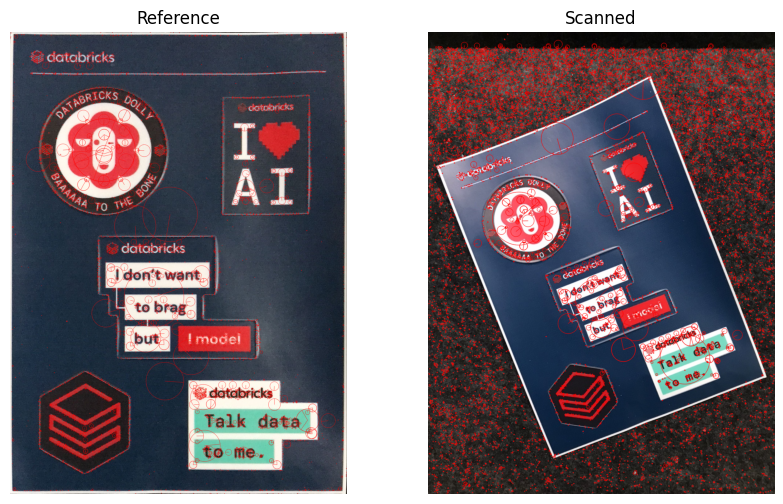

In [8]:
plt.figure(figsize=[10,6]);
plt.subplot(121); plt.axis('off'); plt.imshow(im1_display); plt.title("Reference")
plt.subplot(122); plt.axis('off'); plt.imshow(im2_display); plt.title("Scanned")

# Step 3 : Match keypoints in the two image

In [9]:
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1,descriptors2,k=2)
# Apply ratio test
good = []
for m,n in matches:
  if m.distance < 0.75*n.distance:
    good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(im1,keypoints1,im2,keypoints2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

In [10]:
matches[5]

(< cv2.DMatch 00000275550985D0>, < cv2.DMatch 0000027555098610>)

In [11]:
good[0]

[< cv2.DMatch 00000275550985D0>]

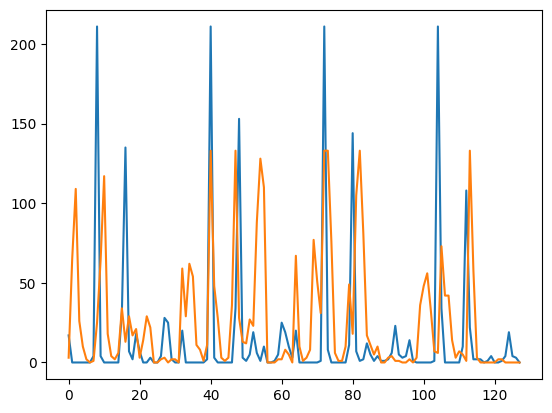

In [12]:
##
d1 = descriptors1[1]
d2 = descriptors2[1]
plt.plot(d1)
plt.plot(d2)

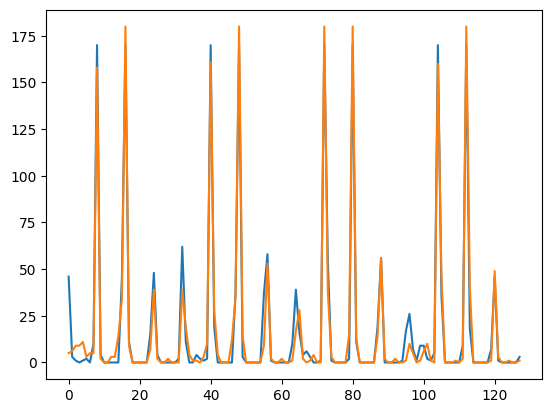

In [13]:
idx = 0
d1 = descriptors1[good[idx][0].queryIdx]
d2 = descriptors2[good[idx][0].trainIdx]
plt.plot(d1)
plt.plot(d2)

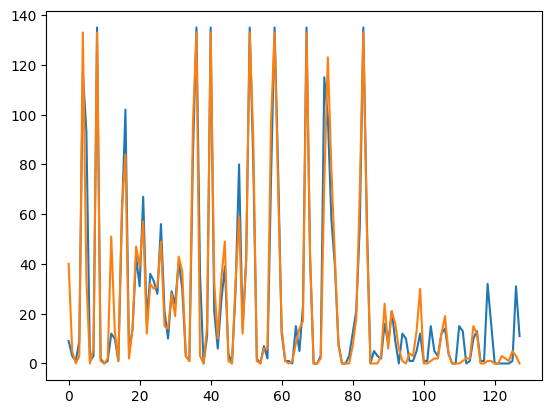

In [14]:
idx = 30
d1 = descriptors1[good[idx][0].queryIdx]
d2 = descriptors2[good[idx][0].trainIdx]
plt.plot(d1)
plt.plot(d2)

(-0.5, 2953.5, 2537.5, -0.5)

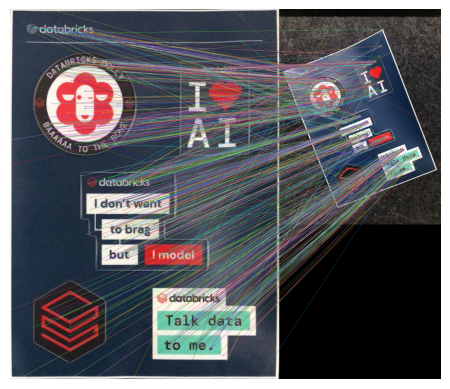

In [15]:
plt.imshow(img3)
plt.axis('off')

# Step 4:  Find Homography

In [16]:
# Extract location of good matches
points1 = np.zeros((len(good), 2), dtype=np.float32)
points2 = np.zeros((len(good), 2), dtype=np.float32)

for i, match in enumerate(good):
  points1[i, :] = keypoints1[match[0].queryIdx].pt
  points2[i, :] = keypoints2[match[0].trainIdx].pt

# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

idx = 10
print("Homography")
print(h)
print("")
print("Point-1 (Reference)")
print(points1[idx, :])
print("")
print("Point-2 (scan)")
print(points2[idx, :])
print("")

print("Express point-2 (scan) in homogeneous coordinates")
p2_homo = np.append(points2[idx, :],1)
print(p2_homo)
print("")

p1_homo = np.matmul(h,p2_homo.T)
print("p1_homo = H * p2_homo")
print(p1_homo)
print("")
print("Normalized p1_homo (Reference)")
print (p1_homo/p1_homo[2])

Homography
[[ 2.36641897e+00 -9.24973350e-01  3.21298618e+02]
 [ 9.24860786e-01  2.36413977e+00 -1.04810039e+03]
 [ 5.14619031e-06  7.61660775e-06  1.00000000e+00]]

Point-1 (Reference)
[148.78275 153.5225 ]

Point-2 (scan)
[ 509.69162 1199.4084 ]

Express point-2 (scan) in homogeneous coordinates
[5.09691620e+02 1.19940845e+03 1.00000000e+00]

p1_homo = H * p2_homo
[4.18021685e+02 2.25886261e+03 1.01175839e+00]

Normalized p1_homo (Reference)
[4.13163546e+02 2.23261070e+03 1.00000000e+00]


 # Step 5: Warp image

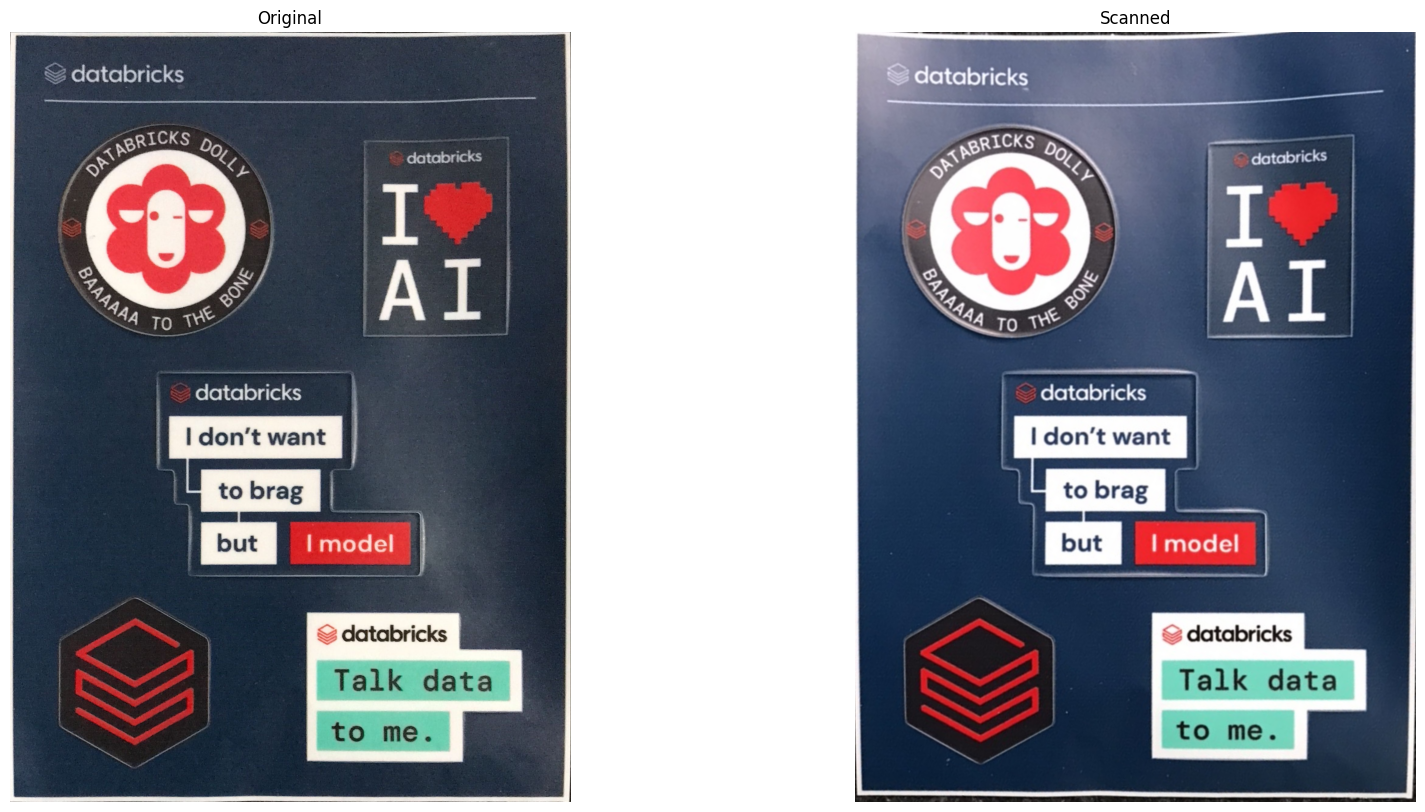

In [17]:
# Use homography to warp image
height, width, channels = im1.shape
im2_warped = cv2.warpPerspective(im2, h, (width, height))
# Display results
plt.figure(figsize=[20,10]);
plt.subplot(121); plt.imshow(im1); plt.axis('off'); plt.title("Original");
plt.subplot(122); plt.imshow(im2_warped); plt.axis('off'); plt.title("Scanned");